# Table of contents
1. [Tune U-net model on real data](#save_best_unet)
2. [Evaluate best model on test images](#evaluate_best_unet)
3. [Train U-net on data augmented with simple augmentations](#train_augmentation_simple)
4. [Evaluate augmented model on test images](#test_augment_simple)
5. [Train U-net on data augmented with Pix2Pix (no jittering)](#augment_pix2pix_no_jittering)
6. [Evaluate augmented model on test images](#evaluate_augment_pix2pix_no_jittering)

# Tune U-net model on real data<a name="tune_unet_on_real"></a>

160 training and 40 validation images are used during training

In [2]:
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, Dropout, Reshape, Conv2DTranspose, Activation, BatchNormalization, LeakyReLU, AveragePooling2D, Flatten, Dense, ReLU, Lambda
import tensorflow as tf
from itertools import product
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt 
import numpy as np
from math import ceil
import tensorflow.keras.backend as K

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Unet model used in this experiment contains 8 times less filters in each layer than original model from https://arxiv.org/pdf/1505.04597.pdf in order to train it in reasonable time with low end GPU

Function for calculating mean intersection over union originates from https://colab.research.google.com/github/zaidalyafeai/Notebooks/blob/master/unet.ipynb

In [3]:
def mean_iou(y_true, y_pred):
    yt0 = K.cast(y_true[:,:,:,0] > 0.5, 'float32')
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [4]:
def false_positives(y_true, y_pred):
    yt0 = K.cast(y_true[:,:,:,0] > 0.5, 'float32')
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    return (tf.math.count_nonzero(yp0) - inter) / BATCH_SIZE

In [5]:
def false_negatives(y_true, y_pred):
    yt0 = K.cast(y_true[:,:,:,0] > 0.5, 'float32')
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    return (tf.math.count_nonzero(yt0) - inter) / BATCH_SIZE

In [6]:
INPUT_CHANNELS = 3
OUTPUT_CHANNELS = 1

In [7]:
# Normalize [-1, 1] input images
def normalize(img):
    img = (img - 127.5) / 127.5
    return img

# Make mask a binary mask
def binarize(mask):
    mask[mask < 0.5] = 0
    mask[mask >= 0.5] = 1
    return mask

In [8]:
KERNEL_INITIALIZER = tf.random_normal_initializer(mean=0., stddev=0.02, seed=1)

In [9]:
def get_encoder_layer(filters, kernel_size, use_batchnorm=True):
    encoder_layer = Sequential([
        Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=2,
            padding='same',
            kernel_initializer=KERNEL_INITIALIZER,
            use_bias=False
        )
    ])

    if use_batchnorm:
        encoder_layer.add(BatchNormalization())

    encoder_layer.add(LeakyReLU(0.2))
    return encoder_layer

In [10]:
def get_decoder_layer(filters, kernel_size, dropout_rate, use_dropout=False):
    decoder_layer = Sequential()
    decoder_layer.add(
        Conv2DTranspose(
            filters=filters,
            kernel_size=kernel_size,
            strides=2,
            padding='same',
            kernel_initializer=KERNEL_INITIALIZER,
            use_bias=False
        )
    )
    decoder_layer.add(BatchNormalization())

    if use_dropout:
        decoder_layer.add(Dropout(dropout_rate))

    decoder_layer.add(ReLU())
    return decoder_layer

In [11]:
def get_generator(dropout_rate):
    inputs = tf.keras.Input(shape=[128, 128, INPUT_CHANNELS])
    outputs = inputs

    downsampling_args = [
        # from (256, 256, 1) to (128, 128, 64)
        {'filters': 64, 'use_batchnorm': False},
        # from (128, 128, 64) to (64, 64, 128)
        {'filters': 128, 'use_batchnorm': False},
        # from (64, 64, 128) to (32, 32, 256)
        {'filters': 256, 'use_batchnorm': True},
        # from (32, 32, 256) to (16, 16, 512)
        {'filters': 512, 'use_batchnorm': True},
        # from (32, 32, 256) to (16, 16, 512)
        {'filters': 512, 'use_batchnorm': True},
        # from (16, 16, 512) to (8, 8, 512)
        {'filters': 512, 'use_batchnorm': True},
        # from (8, 8, 512) to (4, 4, 512)
        {'filters': 512, 'use_batchnorm': True},
    ]

    upsampling_args = [
        {'filters': 512, 'use_dropout': True},
        {'filters': 512, 'use_dropout': True},
        {'filters': 512, 'use_dropout': False},
        {'filters': 256, 'use_dropout': False},
        {'filters': 128, 'use_dropout': False},
        {'filters': 64, 'use_dropout': False}
    ]

    # Add downsampling layers
    skips = []
    for d in downsampling_args:
        outputs = get_encoder_layer(kernel_size=4,**d)(outputs)
        skips.append(outputs)

    # Add upsampling layers and skip connections
    for up, skip in zip(upsampling_args, skips[-2::-1]):
        outputs = get_decoder_layer(kernel_size=4, dropout_rate=dropout_rate, **up)(outputs)
        outputs = Concatenate()([outputs, skip])

    # From (128, 128, ) to (256, 256, 3)
    outputs = Conv2DTranspose(
        filters=OUTPUT_CHANNELS,
        kernel_size=4,
        strides=2,
        padding='same',
        kernel_initializer=KERNEL_INITIALIZER,
        activation='tanh'
    )(outputs)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

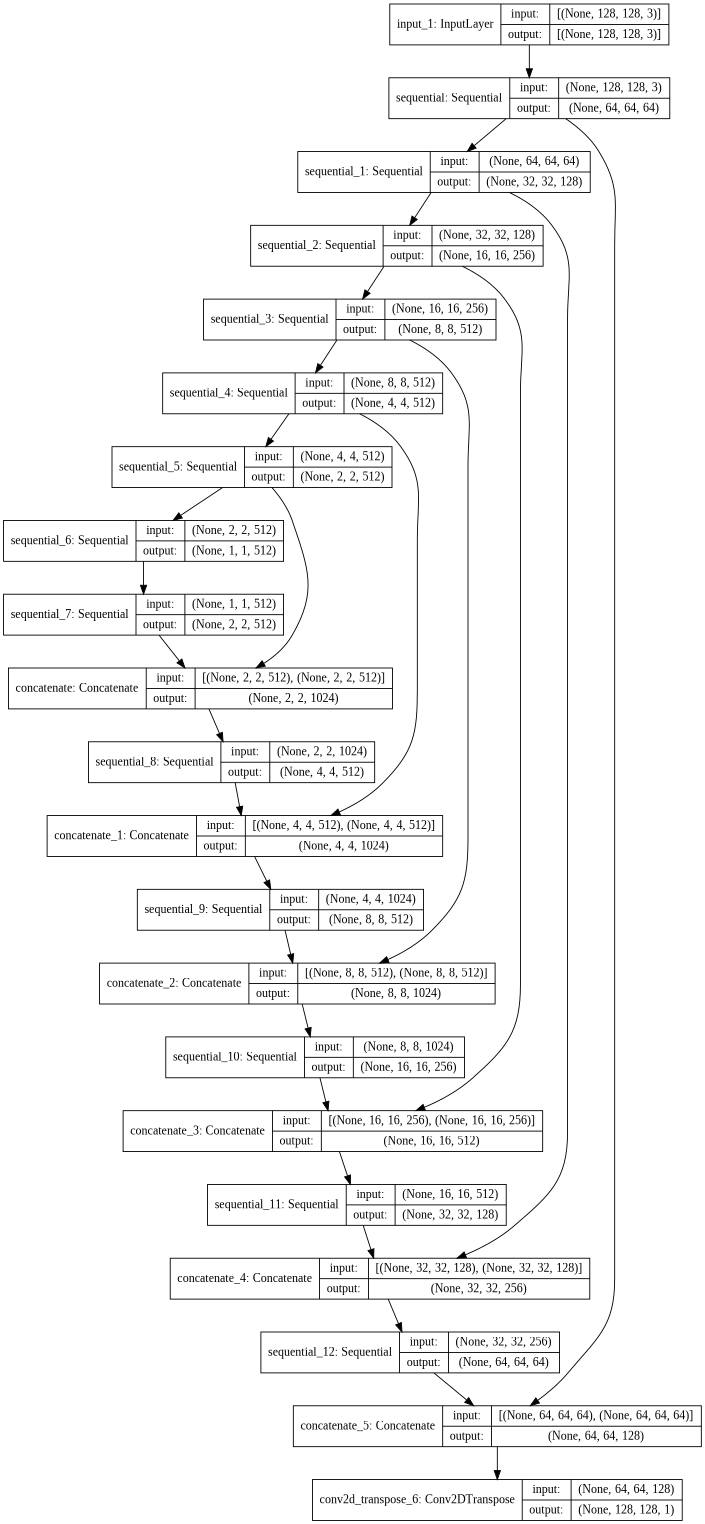

In [12]:
check_model = get_generator(0.5)
tf.keras.utils.plot_model(check_model, show_shapes=True, dpi=64)

In [13]:
def get_model(optimizer, learning_rate, dropout_rate):
    model = get_generator(dropout_rate)

    model.compile(optimizer=optimizer(learning_rate=learning_rate),
                  loss=['binary_crossentropy'],
                  metrics=[
                      mean_iou,
        false_positives,
        false_negatives
    ]
    )
    model.summary()

    return model

### Data generator is used in order not to store all images and segmentation masks in memory at once

In [14]:
image_generator = ImageDataGenerator(
    preprocessing_function=normalize,
    validation_split=0.2
)
mask_generator = ImageDataGenerator(
    preprocessing_function=binarize,
    validation_split=0.2
)

In [15]:
BATCH_SIZE = 16

flow_args = {
    'batch_size': BATCH_SIZE,
    'shuffle': False,
    'target_size': (128, 128),
    'class_mode': None,
    'seed': 1    
}

TRAIN_DIR = '../../dataset'

train_generator = zip(
    image_generator.flow_from_directory(
        directory=TRAIN_DIR,
        classes=['image'],
        color_mode='rgb',
        subset='training',
        **flow_args
    ),
    mask_generator.flow_from_directory(
        directory=TRAIN_DIR,
        classes=['mask'],
        color_mode='grayscale',
        subset='training',
        **flow_args
    )
)

validation_generator = zip(
    image_generator.flow_from_directory(
        directory=TRAIN_DIR,
        classes=['image'],
        color_mode='rgb',
        subset='validation',
        **flow_args
    ),
    mask_generator.flow_from_directory(
        directory=TRAIN_DIR,
        classes=['mask'],
        color_mode='grayscale',
        subset='validation',
        **flow_args
    )
)

dataset_args = {
    'output_types': (tf.float32,) * 2,
    'output_shapes': ([None, 128, 128, 3], [None, 128, 128, 1])
}

train_data = tf.data.Dataset.from_generator(
    generator=lambda: map(tuple, train_generator),
    **dataset_args
)

validation_data = tf.data.Dataset.from_generator(
    generator=lambda: map(tuple, validation_generator),
    **dataset_args
)

Found 2076 images belonging to 1 classes.
Found 2076 images belonging to 1 classes.
Found 518 images belonging to 1 classes.
Found 518 images belonging to 1 classes.


In [16]:
def denormalize(img):
    img = img*127.5+127.5
    return img.astype(np.uint8)

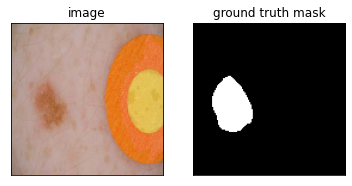

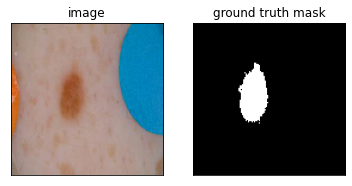

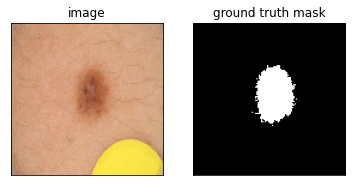

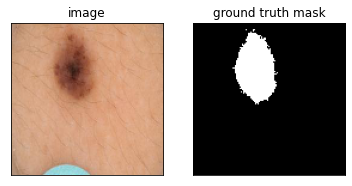

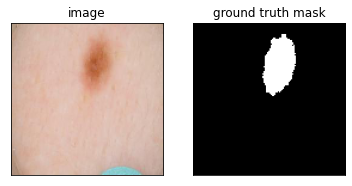

In [17]:
# Check images and masks are loaded properly
images, masks = next(train_generator)

for i, m in list(zip(images, masks))[:5]:
    _, axarr = plt.subplots(1, 2)

    plot_args = {
        'title': ['image', 'ground truth mask'],
        'args': [
            {'X': denormalize(i)},
            {'X': m[:, :, 0], 'cmap': 'gray'},
        ]
    }

    for ax, t, a in zip(axarr, plot_args['title'], plot_args['args']):
        ax.set_title(t)
        fig = ax.imshow(**a)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    plt.show()

In [18]:
class ImageCallback(keras.callbacks.Callback):
    def __init__(self, model):
        self.model = model

    def on_epoch_end(self, epoch, logs=None):
        mask = self.model.predict(images)[0]
        mask[mask < 0.5] = 0
        mask[mask >= 0.5] = 1

        plot_args = {
            'title': ['image', 'predicted mask', 'ground truth mask'],
            'args': [
                {'X': denormalize(images[0])},
                {'X': mask[:, :, 0], 'cmap': 'gray'},
                {'X': masks[0, :, :, 0], 'cmap': 'gray'}
            ]
        }
        _, axarr = plt.subplots(1, 3)

        for ax, t, a in zip(axarr, plot_args['title'], plot_args['args']):
            ax.set_title(t)
            fig = ax.imshow(**a)
            fig.axes.get_xaxis().set_visible(False)
            fig.axes.get_yaxis().set_visible(False)
        plt.show()

In [19]:
TRAIN_COUNT = 2076
VALIDATION_COUNT = 518
TUNE_EPOCHS = 100

In [20]:
def get_callbacks(idx):
    CHECKPOINT_PATH = f'checkpoints/{idx}'
    
    best_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'{CHECKPOINT_PATH}',
        save_best_only=True,
        save_weights_only=True,
        monitor='val_mean_iou',
        mode='max',
        verbose=1
    )

    image_callback = ImageCallback(model)

    LOG_DIR = f'logs/{idx}'
    board_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR)

    stop_callback = tf.keras.callbacks.EarlyStopping(
        monitor='mean_iou', patience=15, mode='max')

    return best_checkpoint, board_callback, image_callback, stop_callback

In [21]:
HYPERPARAMETERS = {
    'optimizer': [tf.keras.optimizers.Adam],
    'learning_rate': [1e-2, 1e-3, 1e-4],
    'dropout_rate': [i/10 for i in range(3, 6)]
}

In [22]:
TEST_DIR = '../../test_dataset/'

flow_args = {k: v for k, v in flow_args.items()}
flow_args['shuffle'] = False

test_generator = zip(
    image_generator.flow_from_directory(
        directory=TEST_DIR,
        classes=['image'],
        color_mode='rgb',
        **flow_args
    ),
    mask_generator.flow_from_directory(
        directory=TEST_DIR,
        classes=['mask'],
        color_mode='grayscale',
        **flow_args
    )
)

test_data = tf.data.Dataset.from_generator(
    generator=lambda: map(tuple, test_generator),
    **dataset_args
)

Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


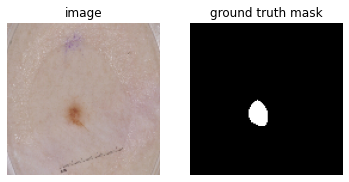

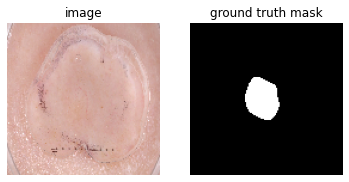

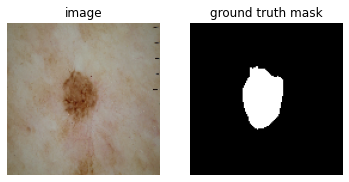

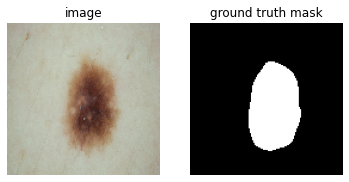

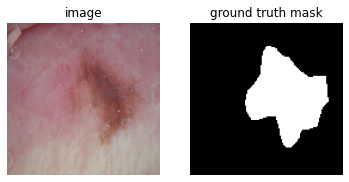

In [23]:
# Check images and masks are loaded properly
images, masks = next(test_generator)

for i, m in list(zip(images, masks))[:5]:
    _, axarr = plt.subplots(1, 2)

    plot_args = {
        'title': ['image', 'ground truth mask'],
        'args': [
            {'X': denormalize(i)},
            {'X': m[:, :, 0], 'cmap': 'gray'},
        ]
    }

    for ax, t, a in zip(axarr, plot_args['title'], plot_args['args']):
        ax.set_title(t)
        ax.axis('off')
        fig = ax.imshow(**a)
    plt.show()

In [32]:
TEST_COUNT = 100

model = get_model(tf.keras.optimizers.Adam, 1e-3, 0.4)
model.load_weights(f'checkpoints/4')

evaluate = model.evaluate(
    test_data,
    steps=ceil(TEST_COUNT/BATCH_SIZE),
    return_dict=True
)
iou = evaluate['mean_iou']
fp = evaluate['false_positives']
fn = evaluate['false_negatives']

print()
print(f'Test mean IoU: {iou:.2f}')
print(f'Test mean false positives: {fp:.2f}')
print(f'Test mean false negatives: {fn:.2f}')

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential_104 (Sequential)     (None, 64, 64, 64)   3072        input_9[0][0]                    
__________________________________________________________________________________________________
sequential_105 (Sequential)     (None, 32, 32, 128)  131072      sequential_104[0][0]             
__________________________________________________________________________________________________
sequential_106 (Sequential)     (None, 16, 16, 256)  525312      sequential_105[0][0]             
___________________________________________________________________________________________

7/7 [==============================] - 15s 2s/step - loss: 0.4079 - mean_iou: 0.7642 - false_positives: 381.0316 - false_negatives: 762.8211

Test mean IoU: 0.74
Test mean false positives: 306.74
Test mean false negatives: 809.98


## Visualize U-Net layers

In [24]:
def get_generator(dropout_rate):
    inputs = tf.keras.Input(shape=[128, 128, INPUT_CHANNELS])
    outputs = inputs

    downsampling_args = [
        # from (256, 256, 1) to (128, 128, 64)
        {'filters': 64, 'use_batchnorm': False},
        # from (128, 128, 64) to (64, 64, 128)
        {'filters': 128, 'use_batchnorm': False},
        # from (64, 64, 128) to (32, 32, 256)
        {'filters': 256, 'use_batchnorm': True},
        # from (32, 32, 256) to (16, 16, 512)
        {'filters': 512, 'use_batchnorm': True},
        # from (32, 32, 256) to (16, 16, 512)
        {'filters': 512, 'use_batchnorm': True},
        # from (16, 16, 512) to (8, 8, 512)
        {'filters': 512, 'use_batchnorm': True},
        # from (8, 8, 512) to (4, 4, 512)
        {'filters': 512, 'use_batchnorm': True},
    ]

    upsampling_args = [
        {'filters': 512, 'use_dropout': True},
        {'filters': 512, 'use_dropout': True},
        {'filters': 512, 'use_dropout': False},
        {'filters': 256, 'use_dropout': False},
        {'filters': 128, 'use_dropout': False},
        {'filters': 64, 'use_dropout': False}
    ]

    # Add downsampling layers
    skips = []
    for d in downsampling_args:
        outputs = get_encoder_layer(kernel_size=4,**d)(outputs)
        skips.append(outputs)

    # Add upsampling layers and skip connections
    ups = []
    for up, skip in zip(upsampling_args, skips[-2::-1]):
        outputs = get_decoder_layer(kernel_size=4, dropout_rate=dropout_rate, **up)(outputs)
        outputs = Concatenate()([outputs, skip])
        ups.append(outputs)

    # From (128, 128, ) to (256, 256, 3)
    outputs = Conv2DTranspose(
        filters=OUTPUT_CHANNELS,
        kernel_size=4,
        strides=2,
        padding='same',
        kernel_initializer=KERNEL_INITIALIZER,
        activation='tanh'
    )(outputs)
    
    return tf.keras.Model(inputs=inputs, outputs= skips + ups + [outputs])

In [25]:
def get_model(optimizer, learning_rate, dropout_rate):
    model = get_generator(dropout_rate)

    model.compile(optimizer=optimizer(learning_rate=learning_rate),
                  loss=['binary_crossentropy'],
                  metrics=[
                      mean_iou,
        false_positives,
        false_negatives
    ]
    )
    model.summary()

    return model

In [27]:
model = get_model(tf.keras.optimizers.Adam, 1e-3, 0.4)
model.load_weights(f'checkpoints/4')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential_13 (Sequential)      (None, 64, 64, 64)   3072        input_2[0][0]                    
__________________________________________________________________________________________________
sequential_14 (Sequential)      (None, 32, 32, 128)  131072      sequential_13[0][0]              
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, 16, 16, 256)  525312      sequential_14[0][0]              
____________________________________________________________________________________________

## Visualize intermediate layers outputs

In [1]:
inp = next(test_generator)[0]
plt.imshow(denormalize(inp[0]))
plt.axis('off')
plt.show()

NameError: name 'test_generator' is not defined

In [ ]:
inp = next(test_generator)[0]
plt.imshow(denormalize(inp[0]))
plt.axis('off')
plt.show()
        
out = model(inp)
for i, o in enumerate(out):
    for j in range(min(16, o.shape[-1])):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(o[0,:,:,j], cmap='gray')
        ax.axis('off')
        plt.show()
        print(o[0,:,:,j].shape)
        fig.savefig(f'images/{i:02d}_{j:02d}.png')

## Visualize weights of convolution kernels

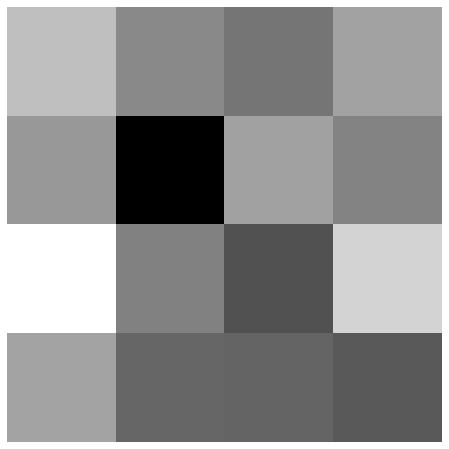

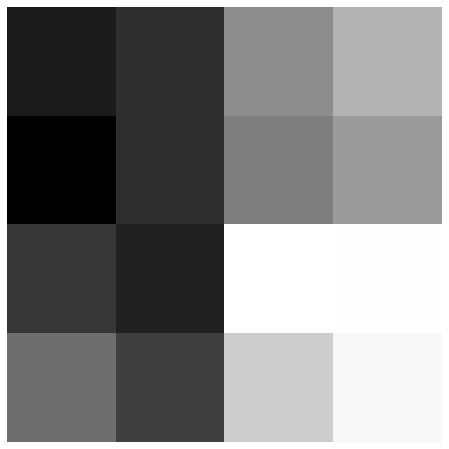

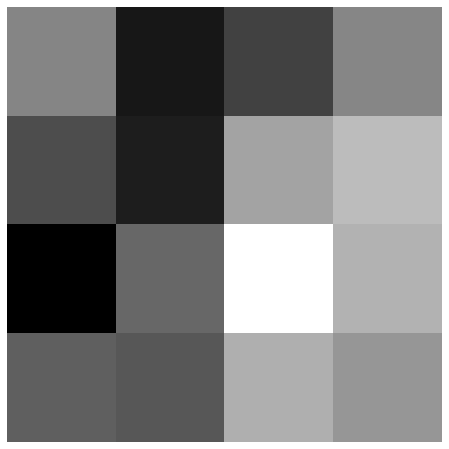

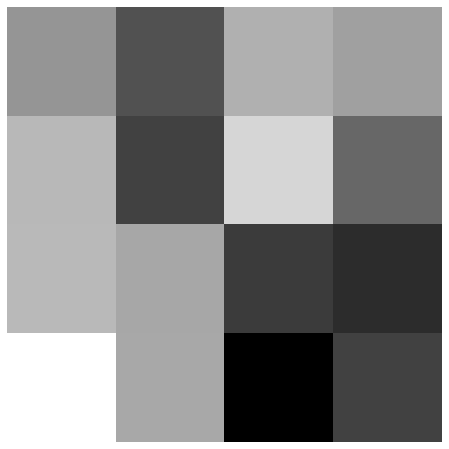

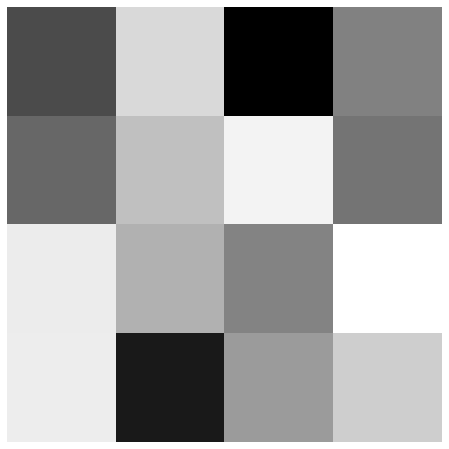

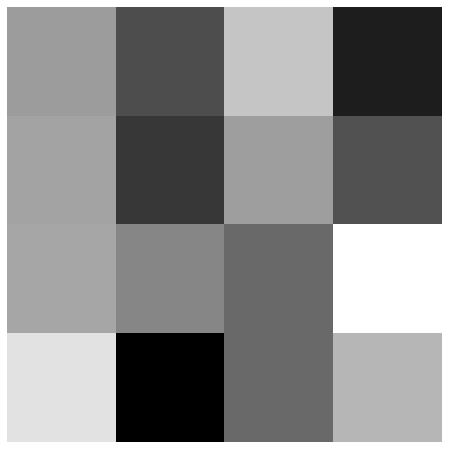

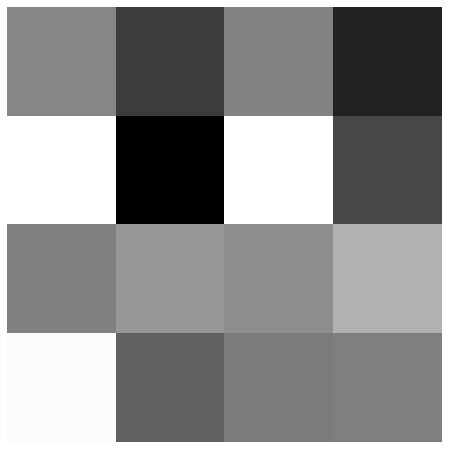

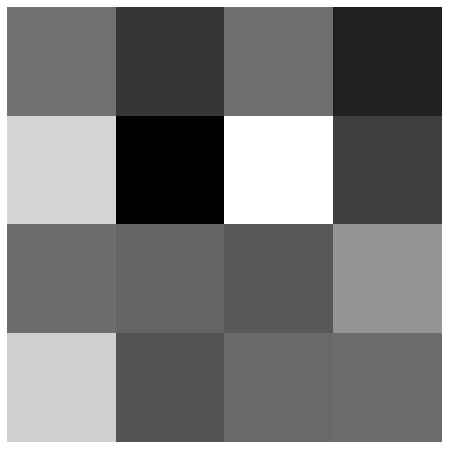

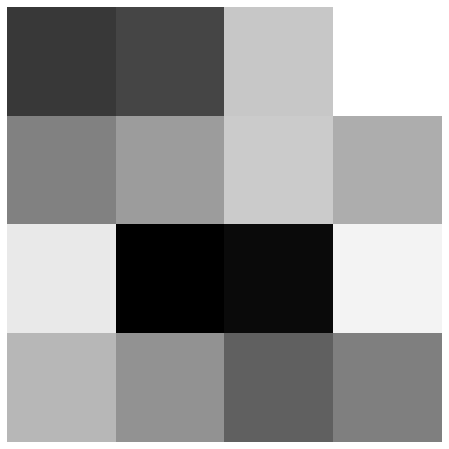

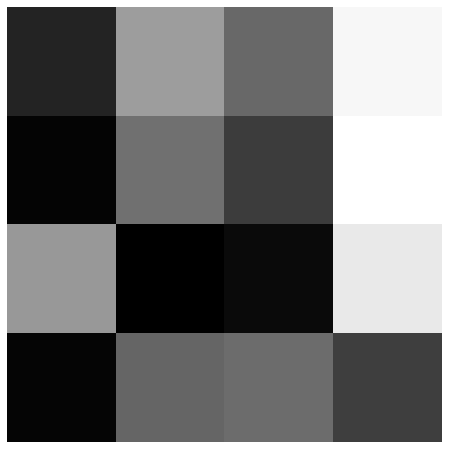

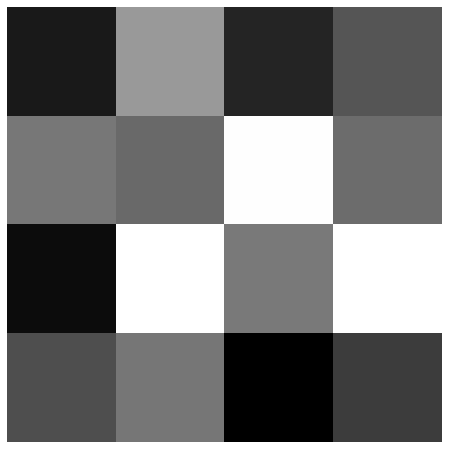

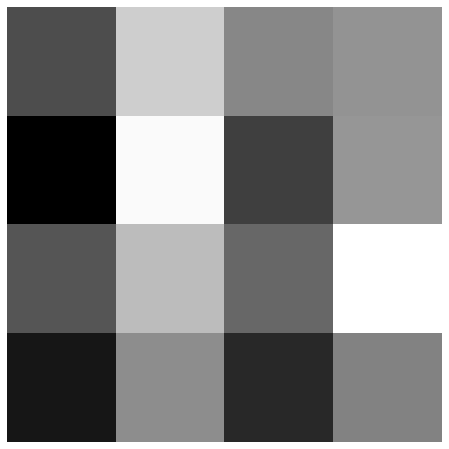

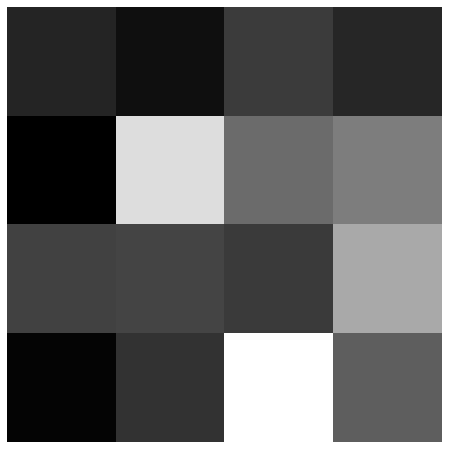

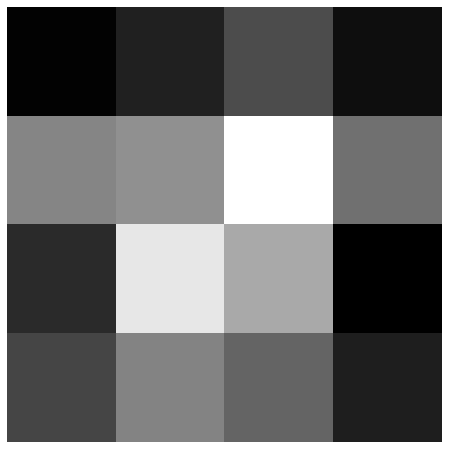

In [37]:
for l in model.layers:
    weights = l.get_weights()
    if len(weights) > 0:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(weights[0][:,:,0,0], cmap='gray')
        ax.axis('off')
        plt.show()